In [58]:
from gensim import corpora, models, similarities
import logging
import pprint
import pandas as pd
import time
import wordcloud
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
import ast
import random

In [59]:
dictionary = corpora.Dictionary.load("data/dictionary.dict")

In [117]:
m = models.LdaModel.load("models/lda-10topics.model")
corpus = pd.read_csv("data/corpus_df.csv", index_col=0)
corpus["text_lem"] = corpus["text_lem"].apply(ast.literal_eval)
corpus["text_vec"] = corpus["text_vec"].apply(ast.literal_eval)

In [61]:
for i in range(10):
    print("===",i)
    top = m.get_topic_terms(topicid=i, topn=15)
    for word in top:
        print("\t",dictionary.get(word[0]), word[1])

=== 0
	 operation 0.0137155563137
	 reuters 0.0124741404772
	 health 0.0110496415098
	 capsule 0.0105978127357
	 will 0.0102749567803
	 english 0.0101703638113
	 hand 0.00868012532475
	 2015 0.00768453513904
	 force 0.00703824611199
	 time 0.00687145831691
	 integrity 0.00565995417872
	 interesting 0.00565792821042
	 gu 0.00537168424711
	 hard 0.00505860540343
	 two 0.00504130059894
=== 1
	 will 0.013056254959
	 operation 0.01225257263
	 health 0.012042747972
	 reuters 0.0109139363064
	 english 0.0106431642429
	 capsule 0.00949730787853
	 force 0.00907455261498
	 2015 0.00817796133654
	 hand 0.0079367370009
	 time 0.00689203435557
	 integrity 0.00519428875413
	 two 0.00504270094199
	 interesting 0.00479931252334
	 business 0.00433984278335
	 hard 0.0042053278133
=== 2
	 health 0.01591191029
	 operation 0.0144098738539
	 will 0.012823269746
	 english 0.0115322103665
	 reuters 0.0112654359911
	 force 0.0094144674534
	 hand 0.00898196255557
	 capsule 0.0071628418873
	 2015 0.0061234638040

In [77]:
def _applyTopicScores(corpus, trainedModel):
    """
    For a given corpus (that has already been vectorised), create x columns, where each column is
    the score for a given topic. 
    """
    for i in corpus.index:
        try:
            scores = trainedModel.get_document_topics(corpus.iloc[i]["text_vec"])
            for topic in scores:
                corpus.at[i, "topic_{}_score".format(topic[0])] = topic[1]
                
        except:
            corpus.drop(i, inplace=True)
            
    return corpus

In [87]:
def _generateSentimentScaledTopicScores(scoredCorpus):
    """
    Create an extra column for each topic, which is the topic weight * sentiment
    """
    cols = [x for x in scoredCorpus.columns if "topic_" in x]
    print(cols)
    for col in cols:
        scoredCorpus["{}_sentiment".format(col)] = scoredCorpus[col] * scoredCorpus["sentiment"]
    return scoredCorpus

In [63]:
def _getTopicRankings(scoredCorpus):
    """
    For a given SCORED corpus, rank the individual topics by popularity.
    """
    topicCols = [x for x in scoredCorpus if "topic_" in x]
    print("aggregating and ranking {} topic's scores".format(len(topicCols)))
    topicScores = []
    if len(topicCols) == 0:
        print("NO TOPIC SCORES")
        return
    for col in topicCols:
        topicScores.append([col[:-6], np.mean(scoredCorpus[col]), int(col[6:-6])])
        
    topicScores.sort(key=lambda x: x[1], reverse=True)
    return topicScores

In [64]:
def _getTopNWords(n, topicNum, model, dictionary):
    """
    Get the top N words from a given topic.
    Returns a list of n * [word, score]
    """
    top = model.get_topic_terms(topicid=topicNum, topn=n)
    newTop = []
    for i in top:
        # Convert to list so we can overwrite
        iList = list(i)
        iList[0] = dictionary.get(iList[0])
        newTop.append(iList)
    return newTop

In [66]:
def _writeWordCloudsFromTopicWords(topicWords):
    date = dt.datetime.now()
    dateString = "{}-{}-{}".format(date.day, date.month, date.year)
    
    for top in range(len(topicWords)):
        topicName = topicWords[top][0]
        scaled = topicWords[top][1]

        # Scale the probabilites to a large enough int (simulate a frequency)
        scaled = [[x[0], int(x[1]*100000)] for x in scaled]

        # Store all the mock frequencies in a dict
        freqDict = {}
        for w in scaled:
            freqDict[w[0]] = w[1]

        wc = wordcloud.wordcloud.WordCloud(stopwords = set(["it"])) # placeholder stopword list
        wc.generate_from_frequencies(freqDict)
        
        wc.to_file("wordclouds/{}_{}.jpg".format(topicName, dateString))

In [88]:
def _getTopicWords(model, scoredCorpus, dictionary, topNTopics):
    """
    Return the top 10 words from every topic in a large object.
    """
    topicRankings = _getTopicRankings(scoredCorpus)
    
    topicWords = []
    for i in range(topNTopics):
        # Get the number of the topic
        topicN = int(topicRankings[i][0].split("_")[1])
        
        # Get the top words from that topic
        thisTopicWords = _getTopNWords(10, topicN, model, dictionary)
        
        # currently just take the top 10 words
        topicWords.append([topicRankings[i][0], [x for x in thisTopicWords]])
    return topicWords
    

In [120]:
def getTopicSentimentRanked(scoredCorpus):
    """
    Get a ranked list of each topic and it's weighted average sentiment score.
    """
    meanSentiments = []
    cols = [x for x in scoredCorpus.columns if "_sentiment" in x]
    
    # Get the mean topic-scaled sentiment across the corpus
    for col in cols:
        topicN = int(col.split("_")[1])
        meanSentiment = np.mean(scoredCorpus[col])
        meanSentiments.append(["topic_{}".format(topicN), meanSentiment, topicN])
    
    meanSentiments = sorted(meanSentiments, key=lambda x: x[1], reverse=True)
    return meanSentiments

In [33]:
def getPopularTopicWords(corpus, model, dictionary, alpha=1):
    """
    MAIN function, alpha still to be defined
    """
    # Apply the topic scores from the trained model
    scoredCorpus = _applyTopicScores(corpus, model)
    scoredCorpus = _generateSentimentScaledTopicScores(scoredCorpus)
    topicSentimentRanked = getTopicSentimentRanked(scoredCorpus)
    
    topicWords = _getTopicWords(m, scoredCorpus, dictionary, 3)
    
    _writeWordCloudsFromTopicWords(topicWords)
        
    for i in topicWords:
        print(i)
    
getPopularTopicWords(corpus, m, dictionary)

aggregating and ranking 10 topic's scores
['topic_9', [['reuters', 0.013386438576220053], ['operation', 0.012359520595505087], ['health', 0.011837904041888845], ['will', 0.01017459467495801], ['force', 0.0096902590003971906], ['english', 0.0093612618857668809], ['time', 0.0083130946136589553], ['2015', 0.0076026287678315208], ['hand', 0.0067927901737888756], ['many', 0.0065010184570367382]]]
['topic_4', [['reuters', 0.010589473697240353], ['will', 0.010517398698629497], ['operation', 0.010293094459915121], ['capsule', 0.0095225239368491709], ['force', 0.0092073894495726324], ['health', 0.0091823122680356941], ['english', 0.0090824760055365026], ['2015', 0.0090552798271213326], ['hand', 0.0083326845713898451], ['interesting', 0.0077566075776112848]]]
['topic_5', [['will', 0.01461365637518687], ['operation', 0.012652496145381775], ['health', 0.010916556043016503], ['english', 0.010907824021794044], ['reuters', 0.0097041000420725436], ['interesting', 0.0073761794553130009], ['capsule', 0.

In [118]:
scoredCorpus = _applyTopicScores(corpus, m)
scoredCorpus = _generateSentimentScaledTopicScores(scoredCorpus)

['topic_0_score', 'topic_1_score', 'topic_2_score', 'topic_3_score', 'topic_4_score', 'topic_5_score', 'topic_6_score', 'topic_7_score', 'topic_8_score', 'topic_9_score']


In [119]:
getTopicSentimentRanked(scoredCorpus)

['topic_0_score_sentiment', 'topic_1_score_sentiment', 'topic_2_score_sentiment', 'topic_3_score_sentiment', 'topic_4_score_sentiment', 'topic_5_score_sentiment', 'topic_6_score_sentiment', 'topic_7_score_sentiment', 'topic_8_score_sentiment', 'topic_9_score_sentiment']


[['topic_5', 0.06171378560091597],
 ['topic_9', 0.06159106656498247],
 ['topic_1', 0.06158730209333807],
 ['topic_4', 0.061527223319109037],
 ['topic_7', 0.061513522795793273],
 ['topic_3', 0.061390017433055714],
 ['topic_0', 0.061170871517811545],
 ['topic_2', 0.060872247934656364],
 ['topic_8', 0.060635157918490133],
 ['topic_6', 0.060314499372883475]]

In [40]:
def join(s):
    return " ".join(s)
    
scoredCorpusTest["text"] = scoredCorpusTest["text_lem"].apply(join)

In [41]:
scoredCorpusTest

,text_lem,text_vec,topic_0_score,topic_1_score,topic_2_score,topic_3_score,topic_4_score,topic_5_score,topic_6_score,topic_7_score,topic_8_score,topic_9_score,text
0,"[official, name, codonopsis, radix, english, n...","[(0, 4), (1, 16), (2, 3), (3, 2), (4, 4), (5, ...",0.099959,0.139282,0.117757,0.082349,0.082545,0.066954,0.105798,0.129587,0.083746,0.092023,official name codonopsis radix english name ta...
1,"[tell, u, story, become, interested, public, h...","[(9, 4), (37, 2), (40, 1), (46, 1), (47, 2), (...",0.106898,0.104129,0.093717,0.107312,0.107182,0.099097,0.108918,0.089813,0.096189,0.086745,tell u story become interested public health p...
2,"[please, make, sure, enter, valid, complete, n...","[(1, 1), (148, 2), (193, 1), (194, 1), (195, 1...",0.094475,0.094876,0.103403,0.126241,0.103779,0.091826,0.076232,0.076216,0.120264,0.112688,please make sure enter valid complete name add...
3,"[hong, kong, association, organize, event, ele...","[(193, 1), (201, 1), (203, 2), (204, 4), (205,...",0.130799,0.094075,0.104856,0.101639,0.110912,0.076242,0.099073,0.112480,0.087058,0.082867,hong kong association organize event electric ...
4,"[electric, vehicle, charge, station, pop, ever...","[(40, 2), (78, 1), (101, 1), (112, 1), (142, 1...",0.078200,0.133324,0.102551,0.092470,0.115266,0.083685,0.094757,0.092787,0.102318,0.104642,electric vehicle charge station pop everywhere...
5,"[traditional, chinese, medicine, tcm, 2000, ye...","[(6, 1), (13, 3), (31, 1), (45, 1), (49, 1), (...",0.106315,0.092177,0.111069,0.079585,0.107715,0.096115,0.109855,0.094765,0.084988,0.117416,traditional chinese medicine tcm 2000 year his...
6,"[select, one, following, topic, learn, chinese...","[(13, 4), (26, 1), (73, 1), (90, 1), (135, 1),...",0.110133,0.080306,0.101358,0.084146,0.074898,0.133391,0.116342,0.095607,0.103515,0.100304,select one following topic learn chinese medic...
7,"[western, physiology, urine, consider, fluid, ...","[(13, 6), (19, 5), (28, 1), (30, 9), (31, 1), ...",0.099831,0.105264,0.081844,0.099809,0.142312,0.094145,0.067518,0.112889,0.090624,0.105764,western physiology urine consider fluid dissol...
8,"[coriolus, versicolor, know, versicolor, name,...","[(1, 2), (11, 7), (13, 6), (31, 10), (32, 1), ...",0.117027,0.083457,0.104854,0.119578,0.090306,0.105936,0.084797,0.078933,0.117104,0.098007,coriolus versicolor know versicolor name yun z...
9,"[mushroom, health, supplement, combine, benefi...","[(1, 2), (6, 1), (11, 8), (13, 13), (31, 17), ...",0.093071,0.089930,0.096211,0.092861,0.090933,0.110018,0.106963,0.099414,0.106307,0.114293,mushroom health supplement combine benefit two...


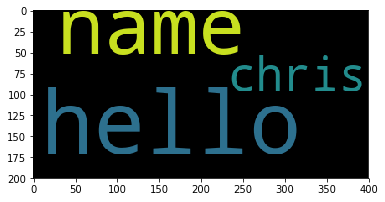

In [153]:
a = wordcloud.wordcloud.WordCloud()

a.generate("hello my name is chris")

a.to_file("test.jpg")

plt.imshow(a)


In [144]:
import wordcloud

In [128]:
wordcloud.wordcloud.

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 'ours',
 '

In [124]:
test = []

for i in range(10):
    time.sleep(1)
    test.append("hello")

KeyboardInterrupt: 